# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [3]:
import io
import os
import numpy as np
import scipy

In [4]:
PATH_TO_DATA = "./data/"

# 1) Monolingual (English) word embeddings 

In [9]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ',1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        scores = {}
        for word in self.word2vec.keys():
            scores[word] = self.score(w, word)
        return sorted(scores, key=scores.get, reverse=True)[1:K+1]

    def score(self, w1, w2):
        v1 = self.word2vec[w1]
        v2 = self.word2vec[w2]
        return np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

In [10]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'))

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 100000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7775108541288563
germany berlin 0.7420295235998394
['cats', 'kitty', 'kitten', 'feline', 'kitties']
['dogs', 'puppy', 'Dog', 'doggie', 'canine']
['dog', 'pooches', 'Dogs', 'doggies', 'canines']
['france', 'Paris', 'london', 'berlin', 'tokyo']
['austria', 'europe', 'german', 'berlin', 'poland']


In [11]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        sentemb = []
        for sent in sentences:
            if idf is False:
                sentemb.append(np.mean([self.w2v.word2vec[w] for w in sent.split() if w in self.w2v.word2vec], axis=0))
            else:
                sentemb.append(np.sum([self.w2v.word2vec[w] * idf[w] for w in sent.split() if w in self.w2v.word2vec and w in idf], axis=0))
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        scores = {}
        for sent in sentences:
            scores[sent] = self.score(s, sent, idf)
        return sorted(scores, key=scores.get, reverse=True)[1:K+1]

    def score(self, s1, s2, idf=False):
        v1 = self.encode([s1], idf)[0]
        v2 = self.encode([s2], idf)[0]
        return np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    
    def build_idf(self, sentences):
        idf = {}
        for sent in sentences:
            for w in set(sent.split()):
                idf[w] = idf.get(w, 0) + 1
        for word in idf:
            idf[word] = max(1, np.log10(len(sentences) / (idf[word])))    
        return idf

In [12]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'))
s2v = BoV(w2v)

sentences = open(os.path.join(PATH_TO_DATA, 'sentences.txt')).read().splitlines() 

# Build idf scores for each word
idf = s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
print(s2v.most_similar('' if not sentences else sentences[10], sentences))  # BoV-mean
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))


print(s2v.most_similar('' if not sentences else sentences[10], sentences, idf))  # BoV-idf
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 100000 pretrained word vectors
['an african american man smiling . ', 'a little african american boy and girl looking up . ', 'an afican american woman standing behind two small african american children . ', 'an african american man is sitting . ', 'a girl in black hat holding an african american baby . ']
0.5726258859719605
['an african american man smiling . ', 'an african american man is sitting . ', 'a little african american boy and girl looking up . ', 'an afican american woman standing behind two small african american children . ', 'a girl in black hat holding an african american baby . ']
0.4751450875368783


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [21]:
# 1 - Download and load 50k first vectors of

eng = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax = 50000)
fra = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax = 50000)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [27]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

en_vocab = set(eng.word2id.keys())
fr_vocab = set(fra.word2id.keys())
common_vocab = list(en_vocab & fr_vocab)

X = []
Y = []
for word in common_vocab:
    X.append(fra.word2vec[word])
    Y.append(eng.word2vec[word])
X = np.matrix(X)
Y = np.matrix(Y)

In [28]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

U, s, V_t = np.linalg.svd(np.dot(X.transpose(), Y))
W = np.dot(U, V_t)
fr_aligned_vectors = np.dot(list(fra.word2vec.values()), W)



In [30]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

fr_aligned = dict()
fr_wordlist = list(fra.word2vec.keys())
for i in range(len(fr_aligned_vectors)):
    fr_aligned[fr_wordlist[i]] = fr_aligned_vectors[i]
    
for w in ['fleur', 'arbre', 'café', 'paris', 'allemagne']:
    scores = {}
    for word in eng.word2vec.keys():
        v1 = fr_aligned[w]
        v2 = eng.word2vec[word]
        scores[word] = np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    print(sorted(scores, key=scores.get, reverse=True)[0:5])  
    
for w in ['cat', 'bottle', 'car', 'hat', 'paris']:
    scores = {}
    for word in fr_aligned.keys():
        v1 = eng.word2vec[w]
        v2 = np.array(fr_aligned[word])[0]
        scores[word] = np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    print(sorted(scores, key=scores.get, reverse=True)[0:5])


['flower', 'flowers', 'rosette', 'flowered', 'petals']
['tree', 'trees', 'understory', 'seedlings', 'shrubs']
['café', 'coffee', 'cafe', 'cafés', 'chocolates']
['paris', 'parisian', 'rouen', 'gallimard', 'sorbonne']
['germany', 'rhineland', 'gelsenkirchen', 'saarland', 'bavaria']
['cat', 'chat', 'dog', 'chats', 'chien']
['bouteille', 'bouteilles', 'flacon', 'bottle', 'vodka']
['voiture', 'voitures', 'automobile', 'porsche', 'automobiles']
['hat', 'chapeau', 'cowboy', 'shirt', 'trick']
['paris', 'parisienne', 'lyon', 'versailles', 'paris,']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [13]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

def load_train_dev(fname, name=''):
    with io.open(fname, encoding='utf-8') as f:

        score=[]
        sentences=[]
        for sent in f:
            score.append(int(sent.split(' ', 1)[0]))
            sentences.append(sent.split(' ', 1)[1])
        #score = [sent.split(' ', 1)[0] for sent in f]
        #sentences = [sent.split(' ', 1)[1] for sent in f]

    print('Loaded %s pretrained sentences from %s set' % (len(sentences), name))
    return [x.strip() for x in sentences], np.array(score)

def load_test(fname, name=''):
    with io.open(fname, encoding='utf-8') as f:
        
        sentences = [sent for sent in f]
        
    print('Loaded %s pretrained sentences from %s set' % (len(sentences), name))
    return [x.strip() for x in sentences]
    
train_x, train_y = load_train_dev(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'), 'train')
dev_x, dev_y = load_train_dev(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'), 'dev')
test_x = load_test(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'), 'test')

Loaded 8544 pretrained sentences from train set
Loaded 1101 pretrained sentences from dev set
Loaded 2210 pretrained sentences from test set


In [14]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=190000)
s2v = BoV(w2v)

train_xvec = np.array(s2v.encode(train_x))
dev_xvec = np.array(s2v.encode(dev_x))
test_xvec = np.array(s2v.encode(test_x))


idf = s2v.build_idf(train_x+dev_x)


train_xidf = np.array(s2v.encode(train_x, idf))
dev_xidf = np.array(s2v.encode(dev_x, idf))
test_xidf = np.array(s2v.encode(test_x, idf))


Loaded 190000 pretrained word vectors


In [15]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

# Function to create a logistic regression model. Return the fitted model
def logReg(data, model_lr=LogisticRegression()):
    train_x = data[0]
    train_y = data[1]
    dev_x = data[2]
    dev_y = data[3]
    model_lr.fit(train_x, train_y) # Fit the model
    pred = model_lr.predict(dev_x) # Predict dev
    print(model)
    print('Train error : ', model_lr.score(train_x, train_y)) # Print score
    print('Dev error : ', accuracy_score(pred, dev_y))
    print('Confusion matrix :')
    print(confusion_matrix(pred, dev_y))
    print('\n')
    return model_lr

''' After a grid_search on weighted/average, C & penalty, 
 the best score on train/dev is reach with idf_average, l2 and C=0.14 '''

# Selection of weighted dataset
average_bov = [train_xvec, train_y, dev_xvec, dev_y]
weighted_bov = [train_xidf, train_y, dev_xidf, dev_y]

# Create and fit the model with optimized parameters, and print some metrics
print(confusion_matrix(dev_y, dev_y))
print('\n')

print('Average of word vectors : ')
model = LogisticRegression(penalty='l2', C=0.16)
model = logReg(average_bov, model)

print('Weighted average of word vectors : ')
model = LogisticRegression(penalty='l2', C=0.14)
model = logReg(weighted_bov, model)


[[139   0   0   0   0]
 [  0 289   0   0   0]
 [  0   0 229   0   0]
 [  0   0   0 279   0]
 [  0   0   0   0 165]]


Average of word vectors : 
LogisticRegression(C=0.16, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Train error :  0.46512172284644193
Dev error :  0.4332425068119891
Confusion matrix :
[[  9   5   2   2   0]
 [109 203  98  50  11]
 [  2   6  14   3   1]
 [ 17  75 110 210 112]
 [  2   0   5  14  41]]


Weighted average of word vectors : 
LogisticRegression(C=0.14, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Train error :  0.5010533707865169
Dev error :  0.4032697547683924
Confusion matrix 

In [16]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

test_y = model.predict(test_xidf)

# Saving results
file = open('data/logreg_bov_y_test_sst.txt', 'w')
for i in test_y:
    file.write(str(i))
    file.write("\n")
file.close()

In [19]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

from sklearn.svm import LinearSVC


def fitting_other_classifier(data, model):
    train_x = data[0]
    train_y = data[1]
    dev_x = data[2]
    dev_y = data[3]
    model.fit(train_x, train_y) # Fit the model
    pred = model.predict(dev_x) # Predict dev
    print(model)
    print('Score on train : ', model.score(train_x, train_y)) # Print score
    print('Score on dev : ', accuracy_score(pred, dev_y))
    print(confusion_matrix(pred, dev_y))
    print('\n')
    # Saving results
    file = open('data/linearsvc_bov_y_test_sst.txt', 'w')
    for i in pred:
        file.write(str(i))
        file.write("\n")
    file.close()
    return model

weighted_bov = [train_xidf, train_y, dev_xidf, dev_y]

# Create and fit the model with optimized parameters, and print some metrics
model = LinearSVC()
model = fitting_other_classifier(weighted_bov, model)



LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Score on train :  0.41947565543071164
Score on dev :  0.35603996366939145
[[ 28  18  12   4   1]
 [ 49 118  50  28   6]
 [ 14  40  29  32   3]
 [ 40 102 118 155  93]
 [  8  11  20  60  62]]




# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [39]:
import keras

In [21]:
# 1 - Load train/dev/test sets of SST

def load_train_dev(fname, name=''):
    with io.open(fname, encoding='utf-8') as f:

        score=[]
        sentences=[]
        for sent in f:
            score.append(int(sent.split(' ', 1)[0]))
            sentences.append(sent.split(' ', 1)[1])

    print('Loaded %s pretrained sentences from %s set' % (len(sentences), name))
    return [x.strip() for x in sentences], np.array(score)

def load_test(fname, name=''):
    with io.open(fname, encoding='utf-8') as f:
        
        sentences = [sent for sent in f]
        
    print('Loaded %s pretrained sentences from %s set' % (len(sentences), name))
    return [x.strip() for x in sentences]

def get_dummies(data): # transform np.array into dummy variable to fit models
    result = np.array([[0 for i in range(data.min(), data.max()+1)] for i in data])
    for i, k in enumerate(data):
        result[i][k] = 1
    return result
    
train_x, train_y = load_train_dev(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'), 'train')
dev_x, dev_y = load_train_dev(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'), 'dev')
test_x = load_test(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'), 'test')

train_y = get_dummies(train_y)
dev_y = get_dummies(dev_y)

Loaded 8544 pretrained sentences from train set
Loaded 1101 pretrained sentences from dev set
Loaded 2210 pretrained sentences from test set


In [22]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

from keras.preprocessing import text

filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
train_all_voc = [word for sent in train_x for word in sent.split(' ')]


train_voc_size = round(len([word for sent in train_x for word in sent.split(' ')])*1.5)

train_int = [text.one_hot(text=sent, n=train_voc_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ") 
             for sent in train_x]
dev_int = [text.one_hot(text=sent, n=train_voc_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ") 
           for sent in dev_x]
test_int = [text.one_hot(text=sent, n=train_voc_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ") 
            for sent in test_x]

train_voc_size

Using TensorFlow backend.


245344

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [23]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

from keras.preprocessing import sequence

max_len = len(max(train_int, key=len))+20

train_int = sequence.pad_sequences(train_int, maxlen=max_len)
dev_int = sequence.pad_sequences(dev_int, maxlen=max_len)
test_int = sequence.pad_sequences(test_int, maxlen=max_len)


## 4.2 - Design and train your model

In [24]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 300  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = train_voc_size  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='sigmoid'))

In [25]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'rmsprop' #'rmsprop' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         73603200  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 73,696,965
Trainable params: 73,696,965
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/3
8544/8544 [==============================] - 258s 30ms/step - loss: 1.5571 - acc: 0.2940 - val_loss: 1.4815 - val_acc: 0.3379
Epoch 2/3
8544/8544 [==============================] - 221s 26ms/step - loss: 1.3490 - acc: 0.4086 - val_loss: 1.3630 - val_acc: 0.3797
Epoch 3/3
8544/8544 [==============================] - 219s 26ms/step - loss: 1.1446 - acc: 0.4603 - val_loss: 1.3883 - val_acc: 0.3815


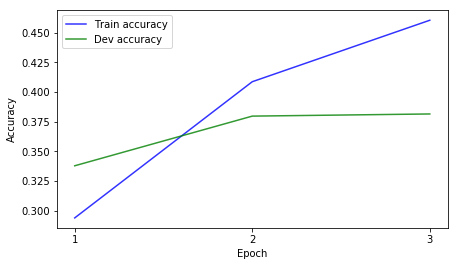

In [26]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW

bs = 64 
n_epochs = 3

x_train = np.array(train_int)
y_train = train_y
x_val = np.array(dev_int)
y_val = dev_y

history = model.fit(x_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_val, y_val))

from matplotlib import pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(history.history['acc'], c='blue', alpha=0.8, label='Train accuracy')
plt.plot(history.history['val_acc'], c='green', alpha=0.8, label='Dev accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([i for i in range(n_epochs)], [i+1 for i in range(n_epochs)])
plt.legend(loc='best')
plt.show()



In [27]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

pred_test = model.predict_classes(test_int)

# Saving results
file = open('data/logreg_lstm_y_test_sst.txt', 'w')
for l in pred_test:
    file.write(str(l))
    file.write("\n")
file.close()

## 4.3 -- innovate !

In [31]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

from keras.preprocessing.text import Tokenizer
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten, Dropout, TimeDistributed

input_len = len(max(train_int, key=len))

model2 = Sequential()
model2.add(Embedding(vocab_size, embed_dim, input_length=input_len))
model2.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dropout(0.3))
model2.add(Dense(50, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(n_classes, activation='sigmoid'))
print(model2.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 69, 300)           73603200  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 62, 32)            76832     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 31, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 992)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 992)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                49650     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________

In [32]:
model2.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
model2.fit(x_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_val, y_val))



Train on 8544 samples, validate on 1101 samples
Epoch 1/3
8544/8544 [==============================] - 248s 29ms/step - loss: 1.5728 - acc: 0.2699 - val_loss: 1.5489 - val_acc: 0.3406
Epoch 2/3
8544/8544 [==============================] - 3492s 409ms/step - loss: 1.4044 - acc: 0.3885 - val_loss: 1.3720 - val_acc: 0.3924
Epoch 3/3
8544/8544 [==============================] - 233s 27ms/step - loss: 1.1162 - acc: 0.4945 - val_loss: 1.4148 - val_acc: 0.3878


In [34]:
model_prediction = model2.predict(test_int, batch_size=bs).argmax(axis=-1)
model_prediction.tofile('conv_y_test_sst.txt', sep="\n")